In [1]:
# !pip install transformers
# !pip install emoji
# !pip install sentencepiece 

In [31]:
import torch
import json
import random
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertModel
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import re
import numpy as np
import emoji
#from transformers import *
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from sklearn.metrics import accuracy_score,f1_score
from sklearn.utils.class_weight import compute_class_weight
#from transformers import LongformerTokenizer, LongformerForSequenceClassification
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, DataLoader
from sklearn.metrics import *


# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 2 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [3]:
def fix_the_random(seed_val = 42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [4]:
fix_the_random(2021)

In [6]:
veParams={
    'max_length':100,
    'path_files': 'bert-base-uncased',
    'what_bert':'weighted',
    'batch_size':24,
    'is_train':True,
    'learning_rate':2e-5,
    'epsilon':1e-8,
    'random_seed':30,
    'epochs':1,
    'to_save':True,
    'weights':[0.53,0.47],
    'frac':0.8,
    'outputDir':'./BERTBASED/'
}

In [7]:
def Diff(a,b):
    return list(set(a) -set(b))

def re_sub(pattern, repl,text):
    return re.sub(pattern, repl, text)



def preprocess_sent(sent):
    sent = re.sub(r"http\S+", "", sent)
    sent = re.sub(r"@\S+", "@user", sent)

    #print(sent)
    sent = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "",sent)
    sent = re_sub(r"/", "",sent)
    sent = emoji.demojize(sent)
    sent = re_sub(r"[:\*]", " ",sent)
    sent = re.sub(' +', ' ', sent)
    return sent

def evalMetric(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    mf1Score = f1_score(y_true, y_pred, average='macro')
    f1Score  = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    area_under_c = auc(fpr, tpr)
    recallScore = recall_score(y_true, y_pred)
    precisionScore = precision_score(y_true, y_pred)
    return {"accuracy": accuracy, 'mF1Score': mf1Score, 'f1Score': f1Score, 'auc': area_under_c, 
            'precision': precisionScore, 'recall': recallScore}


#Creating an attention mask - For actual tokens its set to 1, for padding tokens its set to 0
def create_attention_masks(input_ids):
    attention_masks = []
    for seq in tqdm(input_ids):
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return np.array(attention_masks)

def getFeaturesandLabel(X,y):
    sentences = list(X)
    sentences = ["[CLS] "+ i + " [SEP]"for i in sentences]
    tokenizer_texts = list(map(lambda t: tokenizer.tokenize(t)[:512], tqdm(sentences)))
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tqdm(tokenizer_texts)]
    input_ids = pad_sequences(sequences = input_ids, maxlen = veParams['max_length'], dtype = 'long', padding='post', truncating='post')
    attention_masks_data = create_attention_masks(input_ids)
    X_data = torch.tensor(input_ids)
    attention_masks_data = torch.tensor(attention_masks_data)
    y_data = torch.tensor(y)
    return X_data, attention_masks_data, y_data


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [8]:
import pandas as pd
trainData = pd.read_csv("IRSE_FIRE_2022_Track_Training_Data_preprocessed.csv")

In [9]:
def changeToLabel(text):
    if text =='Useful':
        return 1
    else:
        return 0

In [10]:
trainData['label'] = trainData['Class'].map(changeToLabel)

In [11]:
trainData.head()

,Comments,Surrounding Code Context,Class,label
0,/*test 529*/,-10. int res = 0;\n-9. CURL *curl = NULL;\...,Not Useful,0
1,/*test 525*/,"-2. fprintf(stderr, ""Usage: lib529 [url] [...",Not Useful,0
2,/*done*/,"-10. multi_add_handle(m, curl);\n-9. for(;...",Not Useful,0
3,/*test 529*/,-10. int res = 0;\n-9. CURL *curl = NULL;\...,Not Useful,0
4,/*test 525*/,"-2. fprintf(stderr, ""Usage: lib529 [url] [...",Not Useful,0


In [12]:
X, y  = list(trainData['Comments']), list(trainData['label'])

In [13]:
from sklearn.model_selection import train_test_split

# given:
# features: xs
# ground truth: ys

X_tn, X_v, y_tn, y_v = train_test_split(X, y, test_size=0.15, random_state=2021, stratify=y)

In [14]:
testData = pd.read_csv("IRSE_FIRE_2022_Track_Test_Data_1000.csv")

In [15]:
testData.head()

,Comments,Surrounding Code Context,Class
0,/*READ_INT_FUNCTIONS*/,-5. if (png_ptr != NULL)\n-4. png_war...,Not Useful
1,/*Put the chunk name into png_ptr->chunk_name.*/,"-2. png_read_data(png_ptr, buf, 8);\n-1. ...",Not Useful
2,/*critical*/,"-8. png_crc_read(png_structrp png_ptr, png_byt...",Not Useful
3,/*READ_iCCP|iTXt|pCAL|sCAL|sPLT|tEXt|zTXt|SEQU...,-9. {\n-8. if (warn != 0)\n-7. ...,Not Useful
4,/*ZLIB_VERNUM >= 0x1240*/,#if ZLIB_VERNUM >= 0x1240\n\n/*ZLIB_VERNUM >= ...,Not Useful


In [16]:
testData['label'] = testData['Class'].map(changeToLabel)

In [17]:
X_ts = list(testData['Comments'])
y_ts = list(testData['label'])

In [18]:
tokenizer = BertTokenizer.from_pretrained(veParams['path_files'], do_lower_case = True)

In [19]:
X_train, attention_masks_train, y_train = getFeaturesandLabel(X_tn,y_tn)
X_val, attention_masks_val, y_val = getFeaturesandLabel(X_v,y_v)
X_test, attention_masks_test, y_test = getFeaturesandLabel(X_ts,y_ts)

100%|██████████| 1001/1001 [00:00<00:00, 16985.18it/s]


In [20]:
BATCH_SIZE = 16
#Dataset wrapping tensors.
train_data = TensorDataset(X_train, attention_masks_train, y_train)
val_data = TensorDataset(X_val, attention_masks_val, y_val)
test_data = TensorDataset(X_test, attention_masks_test, y_test)

#Samples elements randomly. If without replacement(default), then sample from a shuffled dataset.
train_sampler = RandomSampler(train_data)
val_sampler = SequentialSampler(val_data)
test_sampler = SequentialSampler(test_data)

#represents a Python iterable over a dataset
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = BATCH_SIZE)
validation_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)


In [22]:
from transformers import BertPreTrainedModel

In [23]:
# Class for weighted bert for sentence classification
class SC_weighted_BERT(BertPreTrainedModel):
    def __init__(self, config,weights):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.weights=weights
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(self.weights).cuda())
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [29]:
def select_model(type_of_model,path,weights=None,label_list=None):
    if(type_of_model=='weighted'):
        model = SC_weighted_BERT.from_pretrained(
        path, # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification             # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        weights=weights
    )
    else:
        print("Error in model name!!!!")
    return model

In [34]:
import torch
import torch.nn as nn

In [29]:
model = select_model(veParams['what_bert'], veParams['path_files'], veParams['weights'])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing SC_weighted_BERT: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing SC_weighted_BERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SC_weighted_BERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SC_weighted_BERT were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['clas

In [24]:
import numpy as np
def getProb(temp):
    t = np.exp(temp)
    return t[1]/(sum(t))


In [25]:
def getPerformanceOfLoader(test_dataloader):
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in test_dataloader:
    #print(batch)
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
  
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Store predictions and true labels
        predictions.extend(logits)
        true_labels.extend(label_ids)

    print('DONE.')
    predict =[]
    proba = []
    for i in predictions:
        if i[0]>= i[1]:
            predict.append(0)
        else:
            predict.append(1)
        proba.append(getProb(i))

    df = pd.DataFrame()
    #df['Comments']=test['Comments']
    df['target'] = predict
    df['score'] = proba
    return df

In [32]:
# Tell pytorch to run this model on the GPU.
model.cuda()

bestValAcc  = 0
bestValMF1  = 0
besttest_df  = None
bestEpochs = -1
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

epochs = 10
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader) 

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
 
    # Evaluate data for one epoch
    origValValue = []
    preValValue  = []
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
        
        origValValue.extend(label_ids)
        valPred_flat = np.argmax(logits, axis=1).flatten()
        preValValue.extend(valPred_flat)

    # Report the final accuracy for this validation run.
    valMf1Score = f1_score(origValValue, preValValue, average='macro')
    if (valMf1Score > bestValMF1):
        bestEpochs = epoch_i
        bestValMF1 = valMf1Score
        bestValAcc  = eval_accuracy/nb_eval_steps
        besttest_df = getPerformanceOfLoader(test_dataloader)
        model.save_pretrained(veParams['outputDir'])
        tokenizer.save_pretrained(veParams['outputDir'])
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
  Batch    40  of    428.    Elapsed: 0:00:07.
  Batch    80  of    428.    Elapsed: 0:00:14.
  Batch   120  of    428.    Elapsed: 0:00:22.
  Batch   160  of    428.    Elapsed: 0:00:29.
  Batch   200  of    428.    Elapsed: 0:00:36.
  Batch   240  of    428.    Elapsed: 0:00:43.
  Batch   280  of    428.    Elapsed: 0:00:50.
  Batch   320  of    428.    Elapsed: 0:00:57.
  Batch   360  of    428.    Elapsed: 0:01:04.
  Batch   400  of    428.    Elapsed: 0:01:11.

  Average training loss: 0.54
  Training epcoh took: 0:01:16

Running Validation...
DONE.
  Accuracy: 0.74
  Validation took: 0:00:12

======== Epoch 2 / 10 ========
Training...
  Batch    40  of    428.    Elapsed: 0:00:07.
  Batch    80  of    428.    Elapsed: 0:00:15.
  Batch   120  of    428.    Elapsed: 0:00:22.
  Batch   160  of    428.    Elapsed: 0:00:29.
  Batch   200  of    428.    Elapsed: 0:00:36.
  Batch   240  of    428.    Elapsed: 0:00:43.
  Batch   280  of    428.

In [38]:
besttest_df

,target,score
0,0,0.001957
1,0,0.162537
2,0,0.262868
3,0,0.086126
4,0,0.002283
...,...,...
996,1,0.608575
997,1,0.834452
998,1,0.996549
999,0,0.236926


In [40]:
testData['pred'] = besttest_df['target']

In [42]:
testData.to_csv("bert_fine_tune_best_val.csv", index = False)

In [43]:
testData

,Comments,Surrounding Code Context,Class,label,pred
0,/*READ_INT_FUNCTIONS*/,-5. if (png_ptr != NULL)\n-4. png_war...,Not Useful,0,0
1,/*Put the chunk name into png_ptr->chunk_name.*/,"-2. png_read_data(png_ptr, buf, 8);\n-1. ...",Not Useful,0,0
2,/*critical*/,"-8. png_crc_read(png_structrp png_ptr, png_byt...",Not Useful,0,0
3,/*READ_iCCP|iTXt|pCAL|sCAL|sPLT|tEXt|zTXt|SEQU...,-9. {\n-8. if (warn != 0)\n-7. ...,Not Useful,0,0
4,/*ZLIB_VERNUM >= 0x1240*/,#if ZLIB_VERNUM >= 0x1240\n\n/*ZLIB_VERNUM >= ...,Not Useful,0,0
...,...,...,...,...,...
996,/*The following document where the background ...,-5. #define PNG_CMAP_NONE 0\n\n /*The fol...,Useful,1,1
997,/*Do all the *safe* initialization - 'safe' me...,-1. } png_image_read_control;\n/* Do all the *...,Useful,1,1
998,/*And set the rest of the structure to NULL to...,-10. * called from here must *not* call png_m...,Useful,1,1
999,"/*Use png_ptr here, not info_ptr, because by e...",-8. static png_uint_32\n-7. png_image_format(p...,Useful,1,0


In [44]:
evalMetric(testData['label'], testData['pred'])

{'accuracy': 0.8981018981018981,
 'mF1Score': 0.8759500991407799,
 'f1Score': 0.823529411764706,
 'auc': 0.8816520186626421,
 'precision': 0.8040540540540541,
 'recall': 0.8439716312056738}

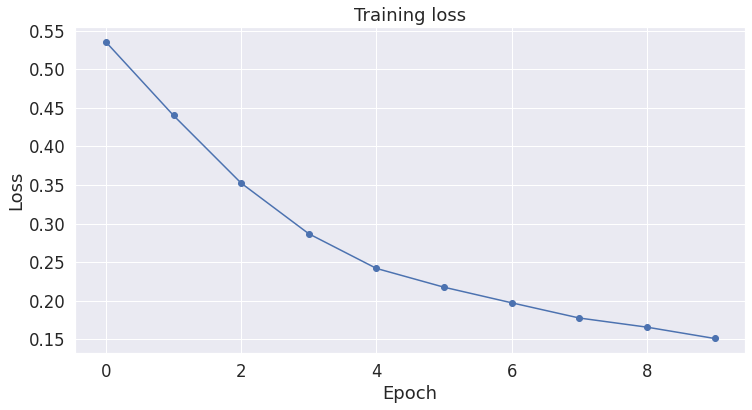

In [36]:
import matplotlib.pyplot as plt
#%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [11]:
testData = pd.read_csv("IRSE_FIRE_2022_Track_Test_Data_1000.csv")
testData['label'] = testData['Class'].map(changeToLabel)

In [12]:
X_ts = list(testData['Comments'])
y_ts = list(testData['label'])

In [26]:
tokenizer = BertTokenizer.from_pretrained(veParams['outputDir'], do_lower_case = True)
X_test, attention_masks_test, y_test = getFeaturesandLabel(X_ts,y_ts)

100%|██████████| 1001/1001 [00:00<00:00, 16225.52it/s]


In [27]:
BATCH_SIZE = 16
test_data = TensorDataset(X_test, attention_masks_test, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = BATCH_SIZE)


In [35]:
model = select_model(veParams['what_bert'], veParams['outputDir'], veParams['weights'])

In [36]:
model.cuda()

SC_weighted_BERT(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [37]:
testPred= getPerformanceOfLoader(test_dataloader)

DONE.


In [41]:
testData

,Comments,Surrounding Code Context,Class,label,pred
0,/*READ_INT_FUNCTIONS*/,-5. if (png_ptr != NULL)\n-4. png_war...,Not Useful,0,0
1,/*Put the chunk name into png_ptr->chunk_name.*/,"-2. png_read_data(png_ptr, buf, 8);\n-1. ...",Not Useful,0,0
2,/*critical*/,"-8. png_crc_read(png_structrp png_ptr, png_byt...",Not Useful,0,0
3,/*READ_iCCP|iTXt|pCAL|sCAL|sPLT|tEXt|zTXt|SEQU...,-9. {\n-8. if (warn != 0)\n-7. ...,Not Useful,0,0
4,/*ZLIB_VERNUM >= 0x1240*/,#if ZLIB_VERNUM >= 0x1240\n\n/*ZLIB_VERNUM >= ...,Not Useful,0,0
...,...,...,...,...,...
996,/*The following document where the background ...,-5. #define PNG_CMAP_NONE 0\n\n /*The fol...,Useful,1,1
997,/*Do all the *safe* initialization - 'safe' me...,-1. } png_image_read_control;\n/* Do all the *...,Useful,1,1
998,/*And set the rest of the structure to NULL to...,-10. * called from here must *not* call png_m...,Useful,1,1
999,"/*Use png_ptr here, not info_ptr, because by e...",-8. static png_uint_32\n-7. png_image_format(p...,Useful,1,0


In [42]:
evalMetric(testData['label'],testData['pred'])

{'accuracy': 0.8981018981018981,
 'mF1Score': 0.8759500991407799,
 'f1Score': 0.823529411764706,
 'auc': 0.8816520186626421,
 'precision': 0.8040540540540541,
 'recall': 0.8439716312056738}

In [43]:
testData.to_csv("only_bert_finetune.csv", index = False)

In [48]:
finalLabel =[]
for index, row in testData.iterrows():
    procComm = preprocess_sent(row['Comments'])
    procCommList = procComm.split()
    if row['pred']==1 and len(procCommList)<=5:
        finalLabel.append(0)
    else:
        finalLabel.append(row['pred'])

In [52]:
testData['pred_fin'] = finalLabel
testData['pred'] = testPred['target']
testData['finalPred'] = finalLabel

In [53]:
testData.to_csv("only_bert_finetune_with_5_tokens.csv", index = False)

In [60]:
testData

,Comments,Surrounding Code Context,Class,label,pred,finalPred
0,/*READ_INT_FUNCTIONS*/,-5. if (png_ptr != NULL)\n-4. png_war...,Not Useful,0,0,0
1,/*Put the chunk name into png_ptr->chunk_name.*/,"-2. png_read_data(png_ptr, buf, 8);\n-1. ...",Not Useful,0,0,0
2,/*critical*/,"-8. png_crc_read(png_structrp png_ptr, png_byt...",Not Useful,0,0,0
3,/*READ_iCCP|iTXt|pCAL|sCAL|sPLT|tEXt|zTXt|SEQU...,-9. {\n-8. if (warn != 0)\n-7. ...,Not Useful,0,0,0
4,/*ZLIB_VERNUM >= 0x1240*/,#if ZLIB_VERNUM >= 0x1240\n\n/*ZLIB_VERNUM >= ...,Not Useful,0,0,0
...,...,...,...,...,...,...
996,/*The following document where the background ...,-5. #define PNG_CMAP_NONE 0\n\n /*The fol...,Useful,1,1,1
997,/*Do all the *safe* initialization - 'safe' me...,-1. } png_image_read_control;\n/* Do all the *...,Useful,1,1,1
998,/*And set the rest of the structure to NULL to...,-10. * called from here must *not* call png_m...,Useful,1,1,1
999,"/*Use png_ptr here, not info_ptr, because by e...",-8. static png_uint_32\n-7. png_image_format(p...,Useful,1,0,0


In [61]:
evalMetric(testData['label'],testData['finalPred'])

{'accuracy': 0.9270729270729271,
 'mF1Score': 0.9062225285125967,
 'f1Score': 0.8620037807183366,
 'auc': 0.891042523599562,
 'precision': 0.9230769230769231,
 'recall': 0.8085106382978723}

In [64]:
print(classification_report(testData['label'],testData['finalPred']))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       719
           1       0.92      0.81      0.86       282

    accuracy                           0.93      1001
   macro avg       0.93      0.89      0.91      1001
weighted avg       0.93      0.93      0.93      1001



In [66]:
confusion_matrix(testData['label'],testData['finalPred'])

array([[700,  19],
       [ 54, 228]])